# Convolutional Neural Networks

## Project: Write an Algorithm for Landmark Classification

---

In this notebook, some template code has already been provided for you, and you will need to implement additional functionality to successfully complete this project. You will not need to modify the included code beyond what is requested. Sections that begin with **'(IMPLEMENTATION)'** in the header indicate that the following block of code will require additional functionality which you must provide. Instructions will be provided for each section, and the specifics of the implementation are marked in the code block with a 'TODO' statement. Please be sure to read the instructions carefully! 

> **Note**: Once you have completed all the code implementations, you need to finalize your work by exporting the Jupyter Notebook as an HTML document. Before exporting the notebook to HTML, all the code cells need to have been run so that reviewers can see the final implementation and output. You can then export the notebook by using the menu above and navigating to **File -> Download as -> HTML (.html)**. Include the finished document along with this notebook as your submission.

In addition to implementing code, there will be questions that you must answer which relate to the project and your implementation. Each section where you will answer a question is preceded by a **'Question X'** header. Carefully read each question and provide thorough answers in the following text boxes that begin with **'Answer:'**. Your project submission will be evaluated based on your answers to each of the questions and the implementation you provide.

>**Note:** Code and Markdown cells can be executed using the **Shift + Enter** keyboard shortcut.  Markdown cells can be edited by double-clicking the cell to enter edit mode.

The rubric contains _optional_ "Stand Out Suggestions" for enhancing the project beyond the minimum requirements. If you decide to pursue the "Stand Out Suggestions", you should include the code in this Jupyter notebook.

---
### Why We're Here

Photo sharing and photo storage services like to have location data for each photo that is uploaded. With the location data, these services can build advanced features, such as automatic suggestion of relevant tags or automatic photo organization, which help provide a compelling user experience. Although a photo's location can often be obtained by looking at the photo's metadata, many photos uploaded to these services will not have location metadata available. This can happen when, for example, the camera capturing the picture does not have GPS or if a photo's metadata is scrubbed due to privacy concerns.

If no location metadata for an image is available, one way to infer the location is to detect and classify a discernable landmark in the image. Given the large number of landmarks across the world and the immense volume of images that are uploaded to photo sharing services, using human judgement to classify these landmarks would not be feasible.

In this notebook, you will take the first steps towards addressing this problem by building models to automatically predict the location of the image based on any landmarks depicted in the image. At the end of this project, your code will accept any user-supplied image as input and suggest the top k most relevant landmarks from 50 possible landmarks from across the world. The image below displays a potential sample output of your finished project.

![Sample landmark classification output](images/sample_landmark_output.png)


### The Road Ahead

We break the notebook into separate steps.  Feel free to use the links below to navigate the notebook.

* [Step 0](#step0): Download Datasets and Install Python Modules
* [Step 1](#step1): Create a CNN to Classify Landmarks (from Scratch)
* [Step 2](#step2): Create a CNN to Classify Landmarks (using Transfer Learning)
* [Step 3](#step3): Write Your Landmark Prediction Algorithm

---
<a id='step0'></a>
## Step 0: Download Datasets and Install Python Modules

**Note: if you are using the Udacity workspace, *YOU CAN SKIP THIS STEP*. The dataset can be found in the `/data` folder and all required Python modules have been installed in the workspace.**

Download the [landmark dataset](https://udacity-dlnfd.s3-us-west-1.amazonaws.com/datasets/landmark_images.zip).
Unzip the folder and place it in this project's home directory, at the location `/landmark_images`.

Install the following Python modules:
* cv2
* matplotlib
* numpy
* PIL
* torch
* torchvision

---

<a id='step1'></a>
## Step 1: Create a CNN to Classify Landmarks (from Scratch)

In this step, you will create a CNN that classifies landmarks.  You must create your CNN _from scratch_ (so, you can't use transfer learning _yet_!), and you must attain a test accuracy of at least 20%.

Although 20% may seem low at first glance, it seems more reasonable after realizing how difficult of a problem this is. Many times, an image that is taken at a landmark captures a fairly mundane image of an animal or plant, like in the following picture.

<img src="images/train/00.Haleakala_National_Park/084c2aa50d0a9249.jpg" alt="Bird in Haleakalā National Park" style="width: 400px;"/>

Just by looking at that image alone, would you have been able to guess that it was taken at the Haleakalā National Park in Hawaii?

An accuracy of 20% is significantly better than random guessing, which would provide an accuracy of just 2%. In Step 2 of this notebook, you will have the opportunity to greatly improve accuracy by using transfer learning to create a CNN.

Remember that practice is far ahead of theory in deep learning.  Experiment with many different architectures, and trust your intuition.  And, of course, have fun!

### (IMPLEMENTATION) Specify Data Loaders for the Landmark Dataset

Use the code cell below to create three separate [data loaders](http://pytorch.org/docs/stable/data.html#torch.utils.data.DataLoader): one for training data, one for validation data, and one for test data. Randomly split the images located at `landmark_images/train` to create the train and validation data loaders, and use the images located at `landmark_images/test` to create the test data loader.

**Note**: Remember that the dataset can be found at `/data/landmark_images/` in the workspace.

All three of your data loaders should be accessible via a dictionary named `loaders_scratch`. Your train data loader should be at `loaders_scratch['train']`, your validation data loader should be at `loaders_scratch['valid']`, and your test data loader should be at `loaders_scratch['test']`.

You may find [this documentation on custom datasets](https://pytorch.org/docs/stable/torchvision/datasets.html#datasetfolder) to be a useful resource.  If you are interested in augmenting your training and/or validation data, check out the wide variety of [transforms](http://pytorch.org/docs/stable/torchvision/transforms.html?highlight=transform)!

In [1]:
### TODO: Write data loaders for training, validation, and test sets
## Specify appropriate transforms, and batch_sizes
import torchvision
import torch
from sklearn.model_selection import train_test_split
from torch.utils.data.dataset import Subset
import numpy as np

batch_size = 128

mean = np.array([0.485, 0.456, 0.406]) # imagenet standards
std = np.array([0.229, 0.224, 0.225]) # imagenet standards

transform = torchvision.transforms.Compose([torchvision.transforms.Resize((224,224)),
                                            torchvision.transforms.ToTensor(),
                                            torchvision.transforms.Normalize(mean,std)])

trainset_before_splitting = torchvision.datasets.ImageFolder('/data/landmark_images/train', transform=transform)
testset = torchvision.datasets.ImageFolder('/data/landmark_images/test', transform=transform)

In [2]:
# split train set to training and validation sets
def train_val_dataset(dataset, validation_split=0.25):
    train_idx, val_idx = train_test_split(list(range(len(dataset))), test_size=validation_split)
    splitted_dataset = {}
    splitted_dataset['train'] = Subset(dataset, train_idx)
    splitted_dataset['validate'] = Subset(dataset, val_idx)
    return splitted_dataset

train_validate_datasets = train_val_dataset(trainset_before_splitting)
trainset = train_validate_datasets['train']
validateset = train_validate_datasets['validate']
print("Train set size = ", len(trainset),
     "\nValidate set size = ", len(validateset),
     "\nTest set size = ", len(testset))

Train set size =  3747 
Validate set size =  1249 
Test set size =  1250


In [3]:
# dataloaders
train_dataloader = torch.utils.data.DataLoader(trainset, batch_size=batch_size, shuffle=True)
validate_dataloader = torch.utils.data.DataLoader(validateset, batch_size=batch_size, shuffle=True)
test_dataloader = torch.utils.data.DataLoader(testset, batch_size=batch_size, shuffle=True)

loaders_scratch = {'train': train_dataloader, 'valid': validate_dataloader, 'test': test_dataloader}

**Question 1:** Describe your chosen procedure for preprocessing the data. 
- How does your code resize the images (by cropping, stretching, etc)?  What size did you pick for the input tensor, and why?
- Did you decide to augment the dataset?  If so, how (through translations, flips, rotations, etc)?  If not, why not?

**Answer**: 
- I used the code "torchvision.transforms.Resize(224,224)" to resize the images to be 224*224 ( This size has been chosen based on a similar dataset in [here](https://towardsdatascience.com/google-landmark-recognition-using-transfer-learning-dde35cc760e1). Moreover, i used imagenet normalization standards.
- No i did not augment the dataset, because the size of the dataset is relatively great. However, I may later augment the dataset to enhance the classifier performance.


### (IMPLEMENTATION) Visualize a Batch of Training Data

Use the code cell below to retrieve a batch of images from your train data loader, display at least 5 images simultaneously, and label each displayed image with its class name (e.g., "Golden Gate Bridge").

Visualizing the output of your data loader is a great way to ensure that your data loading and preprocessing are working as expected.

number of classes: 50

class names: 
 ['00.Haleakala_National_Park', '01.Mount_Rainier_National_Park', '02.Ljubljana_Castle', '03.Dead_Sea', '04.Wroclaws_Dwarves', '05.London_Olympic_Stadium', '06.Niagara_Falls', '07.Stonehenge', '08.Grand_Canyon', '09.Golden_Gate_Bridge', '10.Edinburgh_Castle', '11.Mount_Rushmore_National_Memorial', '12.Kantanagar_Temple', '13.Yellowstone_National_Park', '14.Terminal_Tower', '15.Central_Park', '16.Eiffel_Tower', '17.Changdeokgung', '18.Delicate_Arch', '19.Vienna_City_Hall', '20.Matterhorn', '21.Taj_Mahal', '22.Moscow_Raceway', '23.Externsteine', '24.Soreq_Cave', '25.Banff_National_Park', '26.Pont_du_Gard', '27.Seattle_Japanese_Garden', '28.Sydney_Harbour_Bridge', '29.Petronas_Towers', '30.Brooklyn_Bridge', '31.Washington_Monument', '32.Hanging_Temple', '33.Sydney_Opera_House', '34.Great_Barrier_Reef', '35.Monumento_a_la_Revolucion', '36.Badlands_National_Park', '37.Atomium', '38.Forth_Bridge', '39.Gateway_of_India', '40.Stockholm_City_Hall', '41.Machu

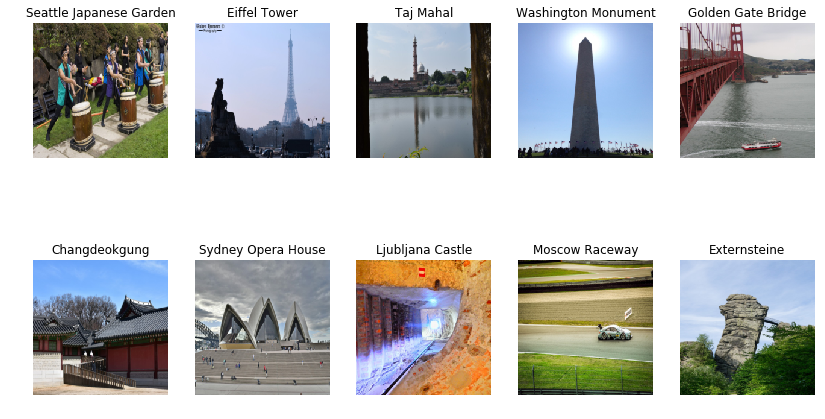

In [4]:
import matplotlib.pyplot as plt
%matplotlib inline
import random

## TODO: visualize a batch of the train data loader
## the class names can be accessed at the `classes` attribute
## of your dataset object (e.g., `train_dataset.classes`)

class_names = trainset_before_splitting.classes
number_classes = len(class_names)

# correct output-size of the CNN
param_output_size = len(class_names)

print("number of classes:", number_classes)
print("")
print("class names: \n", class_names)

# In[32]:
# test train loaders to see how it looks like
# get a batch of training datas

def remove_normlization(figure, std, mean):
    return figure * std[:, None, None] + mean[:, None, None]

fig = plt.figure(figsize=(14,8))
for i in range(10):
    ax = fig.add_subplot(2, 5, i+1)
    random_img = random.randint(0, len(trainset))
    # unnormalize the image
    image = remove_normlization(trainset[random_img][0], torch.Tensor(std), torch.Tensor(mean)) 
    # convert it from tensor to image
    plt.imshow(np.transpose(image.numpy(), (1, 2, 0)))
    plt.title(class_names[trainset[random_img][1]][3:].replace("_", " "))
    plt.axis('off')
plt.show()


### Initialize use_cuda variable

In [5]:
# useful variable that tells us whether we should use the GPU
use_cuda = torch.cuda.is_available()

### (IMPLEMENTATION) Specify Loss Function and Optimizer

Use the next code cell to specify a [loss function](http://pytorch.org/docs/stable/nn.html#loss-functions) and [optimizer](http://pytorch.org/docs/stable/optim.html).  Save the chosen loss function as `criterion_scratch`, and fill in the function `get_optimizer_scratch` below.

In [7]:
## TODO: select loss function
from torch import nn
import torch.optim as optim

criterion_scratch = nn.CrossEntropyLoss()

def get_optimizer_scratch(model):
    ## TODO: select and return an optimizer
    optimizer = optim.Adam(model.parameters(),lr = 0.001)
    return optimizer
    

### (IMPLEMENTATION) Model Architecture

Create a CNN to classify images of landmarks.  Use the template in the code cell below.

In [19]:
# define the CNN architecture
class Net(nn.Module):
    ## TODO: choose an architecture, and complete the class
    def __init__(self):
        super(Net, self).__init__()
        
        # Convolutional layer 1
        self.conv1 = nn.Conv2d(3,16,kernel_size=3,stride=1,padding=1)
        # Convolutional layer 2
        self.conv2 = nn.Conv2d(16,32,kernel_size=3,stride=1,padding=1)
        # Convolutional layer 3
        self.conv3 = nn.Conv2d(32,64,kernel_size=3,stride=1,padding=1)
        
        # Max pooling
        self.pool = nn.MaxPool2d(2, 2)
    
        # Fully connected layer 1
        self.fc1 = nn.Linear(64*28*28,512)
        # Fully connected layer 2
        self.fc2 = nn.Linear(512,128)        
        # Fully connected layer 3
        self.fc3 = nn.Linear(128,number_classes) 
        # Batch normalization
        self.batch_norm = nn.BatchNorm2d(32)
        
        # Activation function
        self.leaky_relu = nn.LeakyReLU(negative_slope=0.2)
        
        # Dropout layer
        self.dropout = nn.Dropout(0.3)

        
    def forward(self, x):
        ## Define forward behavior
        x = self.pool(self.leaky_relu(self.conv1(x)))
        x = self.pool(self.leaky_relu(self.conv2(x)))
        x = self.batch_norm(x)
        x = self.pool(self.leaky_relu(self.conv3(x)))

        # Flatten the image
        x = x.view(-1, 64*28*28)
        
        # Dropout layer
        x = self.dropout(x)
        
        # Hidden layer
        x = self.leaky_relu(self.fc1(x))
        x = self.leaky_relu(self.fc2(x))
        
        # Dropout layer
        x = self.dropout(x)
        
        # final layer
        x = self.fc3(x)

        return x

#-#-# Do NOT modify the code below this line. #-#-#

# instantiate the CNN
model_scratch = Net()

# move tensors to GPU if CUDA is available
if use_cuda:
    model_scratch.cuda()

In [20]:
! pip install torchsummary

In [21]:
from torchsummary import summary 

summary(model_scratch, (3, 224, 224))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1         [-1, 16, 224, 224]             448
         LeakyReLU-2         [-1, 16, 224, 224]               0
         MaxPool2d-3         [-1, 16, 112, 112]               0
            Conv2d-4         [-1, 32, 112, 112]           4,640
         LeakyReLU-5         [-1, 32, 112, 112]               0
         MaxPool2d-6           [-1, 32, 56, 56]               0
       BatchNorm2d-7           [-1, 32, 56, 56]              64
            Conv2d-8           [-1, 64, 56, 56]          18,496
         LeakyReLU-9           [-1, 64, 56, 56]               0
        MaxPool2d-10           [-1, 64, 28, 28]               0
          Dropout-11                [-1, 50176]               0
           Linear-12                  [-1, 512]      25,690,624
        LeakyReLU-13                  [-1, 512]               0
           Linear-14                  [

__Question 2:__ Outline the steps you took to get to your final CNN architecture and your reasoning at each step.  

__Answer:__  
Based on the articles in [1](https://towardsdatascience.com/a-guide-to-an-efficient-way-to-build-neural-network-architectures-part-ii-hyper-parameter-42efca01e5d7), and [2](https://www.analyticsvidhya.com/blog/2021/08/beginners-guide-to-convolutional-neural-network-with-implementation-in-python/), I built a simple CNN network that i believe will suit the project.
After many trail and error attempts, I've reached this CNN architecture which consists of:
- 3 convolutional layers
- max pooling layers with size 2*2 after each convolutional layer
- 3 fully connected layers
- leaky relu activation function
- batch normalization
- dropout

I've used max pooling after each convolutional layer to focus on the target features. Moreover, to reduce overfitting, I used a 0.3 dropout rate. Additionally, I used batch normalization to speed up the training. 

### (IMPLEMENTATION) Implement the Training Algorithm

Implement your training algorithm in the code cell below.  [Save the final model parameters](http://pytorch.org/docs/master/notes/serialization.html) at the filepath stored in the variable `save_path`.

In [22]:
def train(n_epochs, loaders, model, optimizer, criterion, use_cuda, save_path):
    """returns trained model"""
    # initialize tracker for minimum validation loss
    valid_loss_min = np.Inf 
    
    for epoch in range(1, n_epochs+1):
        # initialize variables to monitor training and validation loss
        train_loss = 0.0
        valid_loss = 0.0
        
        ###################
        # train the model #
        ###################
        # set the module to training mode
        model.train()
        for batch_idx, (data, target) in enumerate(loaders['train']):
            # move to GPU
            if use_cuda:
                data, target = data.cuda(), target.cuda()

            ## TODO: find the loss and update the model parameters accordingly
            optimizer.zero_grad()
            output = model(data)
            loss = criterion(output, target)
            loss.backward()
            optimizer.step()
            ## record the average training loss, using something like
            train_loss = train_loss + ((1 / (batch_idx + 1)) * (loss.data.item() - train_loss))           
            

        ######################    
        # validate the model #
        ######################
        # set the model to evaluation mode
        model.eval()
        for batch_idx, (data, target) in enumerate(loaders['valid']):
            # move to GPU
            if use_cuda:
                data, target = data.cuda(), target.cuda()

            ## TODO: update average validation loss 
            output = model(data)
            loss = criterion(output, target)
            valid_loss += ((1 / (batch_idx + 1)) * (loss.data.item() - valid_loss))

            
            

        # print training/validation statistics 
        print('Epoch: {} \tTraining Loss: {:.6f} \tValidation Loss: {:.6f}'.format(
            epoch, 
            train_loss,
            valid_loss
            ))

        ## TODO: if the validation loss has decreased, save the model at the filepath stored in save_path
        if valid_loss <= valid_loss_min:
            print('Validation loss decreased ({:.4f} --> {:.4f}), model saved'.format(valid_loss_min,
                                                                                            valid_loss))
            torch.save(model.state_dict(), save_path)
            valid_loss_min = valid_loss

        
        
    return model

### (IMPLEMENTATION) Experiment with the Weight Initialization

Use the code cell below to define a custom weight initialization, and then train with your weight initialization for a few epochs. Make sure that neither the training loss nor validation loss is `nan`.

Later on, you will be able to see how this compares to training with PyTorch's default weight initialization.

In [23]:
def custom_weight_init(m):
    ## TODO: implement a weight initialization strategy
    # Ref: https://gist.github.com/jojonki/be1e8af97dfa12c983446391c3640b68
    if isinstance(m, nn.Conv2d):
        n = m.kernel_size[0] * m.kernel_size[1] * m.out_channels
        m.weight.data.normal_(0, np.sqrt(2. / n))
        if m.bias is not None:
            m.bias.data.zero_()
    elif isinstance(m, nn.BatchNorm2d):
        m.weight.data.fill_(1)
        m.bias.data.zero_()
    elif isinstance(m, nn.Linear):
        n = m.in_features
        y = 1.0/np.sqrt(n)
        m.weight.data.normal_(0, y)
        m.bias.data.zero_()  
    

#-#-# Do NOT modify the code below this line. #-#-#
model_scratch.apply(custom_weight_init)
model_scratch = train(20, loaders_scratch, model_scratch, get_optimizer_scratch(model_scratch),
                      criterion_scratch, use_cuda, 'ignore.pt')

Epoch: 1 	Training Loss: 8.322742 	Validation Loss: 3.802256
Validation loss decreased (inf --> 3.8023), model saved
Epoch: 2 	Training Loss: 3.743800 	Validation Loss: 3.563969
Validation loss decreased (3.8023 --> 3.5640), model saved
Epoch: 3 	Training Loss: 3.374015 	Validation Loss: 3.420589
Validation loss decreased (3.5640 --> 3.4206), model saved
Epoch: 4 	Training Loss: 2.990119 	Validation Loss: 3.296686
Validation loss decreased (3.4206 --> 3.2967), model saved
Epoch: 5 	Training Loss: 2.471693 	Validation Loss: 3.405420
Epoch: 6 	Training Loss: 1.906232 	Validation Loss: 3.374552
Epoch: 7 	Training Loss: 1.206116 	Validation Loss: 3.609762
Epoch: 8 	Training Loss: 0.776571 	Validation Loss: 3.828928
Epoch: 9 	Training Loss: 0.488964 	Validation Loss: 3.902057
Epoch: 10 	Training Loss: 0.270912 	Validation Loss: 4.211147
Epoch: 11 	Training Loss: 0.191489 	Validation Loss: 4.218621
Epoch: 12 	Training Loss: 0.124388 	Validation Loss: 4.540937
Epoch: 13 	Training Loss: 0.1167

### (IMPLEMENTATION) Train and Validate the Model

Run the next code cell to train your model.

In [24]:
## TODO: you may change the number of epochs if you'd like,
## but changing it is not required
num_epochs = 20 # 100

#-#-# Do NOT modify the code below this line. #-#-#

# function to re-initialize a model with pytorch's default weight initialization
def default_weight_init(m):
    reset_parameters = getattr(m, 'reset_parameters', None)
    if callable(reset_parameters):
        m.reset_parameters()

# reset the model parameters
model_scratch.apply(default_weight_init)

# train the model
model_scratch = train(num_epochs, loaders_scratch, model_scratch, get_optimizer_scratch(model_scratch), 
                      criterion_scratch, use_cuda, 'model_scratch.pt')

Epoch: 1 	Training Loss: 3.828219 	Validation Loss: 3.587366
Validation loss decreased (inf --> 3.5874), model saved
Epoch: 2 	Training Loss: 3.336550 	Validation Loss: 3.292357
Validation loss decreased (3.5874 --> 3.2924), model saved
Epoch: 3 	Training Loss: 2.873586 	Validation Loss: 3.110794
Validation loss decreased (3.2924 --> 3.1108), model saved
Epoch: 4 	Training Loss: 2.278485 	Validation Loss: 3.090255
Validation loss decreased (3.1108 --> 3.0903), model saved
Epoch: 5 	Training Loss: 1.493460 	Validation Loss: 3.195714
Epoch: 6 	Training Loss: 0.842140 	Validation Loss: 3.837432
Epoch: 7 	Training Loss: 0.465335 	Validation Loss: 4.317661
Epoch: 8 	Training Loss: 0.246297 	Validation Loss: 4.559172
Epoch: 9 	Training Loss: 0.158101 	Validation Loss: 4.616451
Epoch: 10 	Training Loss: 0.127696 	Validation Loss: 5.100290
Epoch: 11 	Training Loss: 0.128039 	Validation Loss: 5.048445
Epoch: 12 	Training Loss: 0.080833 	Validation Loss: 5.471501
Epoch: 13 	Training Loss: 0.0630

### (IMPLEMENTATION) Test the Model

Run the code cell below to try out your model on the test dataset of landmark images. Run the code cell below to calculate and print the test loss and accuracy.  Ensure that your test accuracy is greater than 20%.

In [25]:
def test(loaders, model, criterion, use_cuda):

    # monitor test loss and accuracy
    test_loss = 0.
    correct = 0.
    total = 0.

    # set the module to evaluation mode
    model.eval()

    for batch_idx, (data, target) in enumerate(loaders['test']):
        # move to GPU
        if use_cuda:
            data, target = data.cuda(), target.cuda()
        # forward pass: compute predicted outputs by passing inputs to the model
        output = model(data)
        # calculate the loss
        loss = criterion(output, target)
        # update average test loss 
        test_loss = test_loss + ((1 / (batch_idx + 1)) * (loss.data.item() - test_loss))
        # convert output probabilities to predicted class
        pred = output.data.max(1, keepdim=True)[1]
        # compare predictions to true label
        correct += np.sum(np.squeeze(pred.eq(target.data.view_as(pred))).cpu().numpy())
        total += data.size(0)
            
    print('Test Loss: {:.6f}\n'.format(test_loss))

    print('\nTest Accuracy: %2d%% (%2d/%2d)' % (
        100. * correct / total, correct, total))

# load the model that got the best validation accuracy
model_scratch.load_state_dict(torch.load('model_scratch.pt'))
test(loaders_scratch, model_scratch, criterion_scratch, use_cuda)

Test Loss: 2.916069


Test Accuracy: 28% (353/1250)


---
<a id='step2'></a>
## Step 2: Create a CNN to Classify Landmarks (using Transfer Learning)

You will now use transfer learning to create a CNN that can identify landmarks from images.  Your CNN must attain at least 60% accuracy on the test set.

### (IMPLEMENTATION) Specify Data Loaders for the Landmark Dataset

Use the code cell below to create three separate [data loaders](http://pytorch.org/docs/stable/data.html#torch.utils.data.DataLoader): one for training data, one for validation data, and one for test data. Randomly split the images located at `landmark_images/train` to create the train and validation data loaders, and use the images located at `landmark_images/test` to create the test data loader.

All three of your data loaders should be accessible via a dictionary named `loaders_transfer`. Your train data loader should be at `loaders_transfer['train']`, your validation data loader should be at `loaders_transfer['valid']`, and your test data loader should be at `loaders_transfer['test']`.

If you like, **you are welcome to use the same data loaders from the previous step**, when you created a CNN from scratch.

In [8]:
### TODO: Write data loaders for training, validation, and test sets
## Specify appropriate transforms, and batch_sizes
batch_size = 40
train_dataloader = torch.utils.data.DataLoader(trainset, batch_size=batch_size, shuffle=True)
validate_dataloader = torch.utils.data.DataLoader(validateset, batch_size=batch_size, shuffle=True)
test_dataloader = torch.utils.data.DataLoader(testset, batch_size=batch_size, shuffle=True)
loaders_transfer = {'train': train_dataloader, 'valid': validate_dataloader, 'test': test_dataloader}

### (IMPLEMENTATION) Specify Loss Function and Optimizer

Use the next code cell to specify a [loss function](http://pytorch.org/docs/stable/nn.html#loss-functions) and [optimizer](http://pytorch.org/docs/stable/optim.html).  Save the chosen loss function as `criterion_transfer`, and fill in the function `get_optimizer_transfer` below.

In [9]:
## TODO: select loss function
criterion_transfer = nn.CrossEntropyLoss()

def get_optimizer_transfer(model):
    ## TODO: select and return optimizer
    optimizer = optim.Adam(model.parameters(),lr = 0.0001)
    return optimizer
    

### (IMPLEMENTATION) Model Architecture

Use transfer learning to create a CNN to classify images of landmarks.  Use the code cell below, and save your initialized model as the variable `model_transfer`.

In [10]:
## TODO: Specify model architecture
from torchvision import models

model_transfer = models.resnet50(pretrained=True)
model_transfer.fc = nn.Linear(2048, 50)

#-#-# Do NOT modify the code below this line. #-#-#

if use_cuda:
    model_transfer = model_transfer.cuda()

__Question 3:__ Outline the steps you took to get to your final CNN architecture and your reasoning at each step.  Describe why you think the architecture is suitable for the current problem.

__Answer:__  
I used ResNet-50 for transfer learning, because ResNet-50 has been trained with large amount of images (on imagenet dataset), thus ResNet-50 learnt rich features. Moreover, ResNet-50 consists of 50 layers that allow the network to learn deeper features about the input images.

### (IMPLEMENTATION) Train and Validate the Model

Train and validate your model in the code cell below.  [Save the final model parameters](http://pytorch.org/docs/master/notes/serialization.html) at filepath `'model_transfer.pt'`.

In [11]:
def train(n_epochs, loaders, model, optimizer, criterion, use_cuda, save_path):
    """returns trained model"""
    # initialize tracker for minimum validation loss
    valid_loss_min = np.Inf 
    
    for epoch in range(1, n_epochs+1):
        # initialize variables to monitor training and validation loss
        train_loss = 0.0
        valid_loss = 0.0
        
        ###################
        # train the model #
        ###################
        # set the module to training mode
        model.train()
        for batch_idx, (data, target) in enumerate(loaders['train']):
            # move to GPU
            if use_cuda:
                data, target = data.cuda(), target.cuda()

            ## TODO: find the loss and update the model parameters accordingly
            optimizer.zero_grad()
            output = model(data)
            loss = criterion(output, target)
            loss.backward()
            optimizer.step()
            ## record the average training loss, using something like
            train_loss = train_loss + ((1 / (batch_idx + 1)) * (loss.data.item() - train_loss))           
            

        ######################    
        # validate the model #
        ######################
        # set the model to evaluation mode
        model.eval()
        for batch_idx, (data, target) in enumerate(loaders['valid']):
            # move to GPU
            if use_cuda:
                data, target = data.cuda(), target.cuda()

            ## TODO: update average validation loss 
            output = model(data)
            loss = criterion(output, target)
            valid_loss += ((1 / (batch_idx + 1)) * (loss.data.item() - valid_loss))

            
            

        # print training/validation statistics 
        print('Epoch: {} \tTraining Loss: {:.6f} \tValidation Loss: {:.6f}'.format(
            epoch, 
            train_loss,
            valid_loss
            ))

        ## TODO: if the validation loss has decreased, save the model at the filepath stored in save_path
        if valid_loss <= valid_loss_min:
            print('Validation loss decreased ({:.4f} --> {:.4f}), model saved'.format(valid_loss_min,
                                                                                            valid_loss))
            torch.save(model.state_dict(), save_path)
            valid_loss_min = valid_loss

        
        
    return model

def test(loaders, model, criterion, use_cuda):

    # monitor test loss and accuracy
    test_loss = 0.
    correct = 0.
    total = 0.

    # set the module to evaluation mode
    model.eval()

    for batch_idx, (data, target) in enumerate(loaders['test']):
        # move to GPU
        if use_cuda:
            data, target = data.cuda(), target.cuda()
        # forward pass: compute predicted outputs by passing inputs to the model
        output = model(data)
        # calculate the loss
        loss = criterion(output, target)
        # update average test loss 
        test_loss = test_loss + ((1 / (batch_idx + 1)) * (loss.data.item() - test_loss))
        # convert output probabilities to predicted class
        pred = output.data.max(1, keepdim=True)[1]
        # compare predictions to true label
        correct += np.sum(np.squeeze(pred.eq(target.data.view_as(pred))).cpu().numpy())
        total += data.size(0)
            
    print('Test Loss: {:.6f}\n'.format(test_loss))

    print('\nTest Accuracy: %2d%% (%2d/%2d)' % (
        100. * correct / total, correct, total))


In [12]:
# TODO: train the model and save the best model parameters at filepath 'model_transfer.pt'
train(30, loaders_transfer, model_transfer, get_optimizer_transfer(model_transfer), criterion_transfer,
       use_cuda, 'model_transfer.pt')


#-#-# Do NOT modify the code below this line. #-#-#

# load the model that got the best validation accuracy
model_transfer.load_state_dict(torch.load('model_transfer.pt'))

Epoch: 1 	Training Loss: 2.255733 	Validation Loss: 1.061864
Validation loss decreased (inf --> 1.0619), model saved
Epoch: 2 	Training Loss: 0.731235 	Validation Loss: 0.800356
Validation loss decreased (1.0619 --> 0.8004), model saved
Epoch: 3 	Training Loss: 0.254046 	Validation Loss: 0.695375
Validation loss decreased (0.8004 --> 0.6954), model saved
Epoch: 4 	Training Loss: 0.084765 	Validation Loss: 0.668656
Validation loss decreased (0.6954 --> 0.6687), model saved
Epoch: 5 	Training Loss: 0.026962 	Validation Loss: 0.646099
Validation loss decreased (0.6687 --> 0.6461), model saved
Epoch: 6 	Training Loss: 0.015621 	Validation Loss: 0.605803
Validation loss decreased (0.6461 --> 0.6058), model saved
Epoch: 7 	Training Loss: 0.008904 	Validation Loss: 0.604145
Validation loss decreased (0.6058 --> 0.6041), model saved
Epoch: 8 	Training Loss: 0.005847 	Validation Loss: 0.586828
Validation loss decreased (0.6041 --> 0.5868), model saved
Epoch: 9 	Training Loss: 0.004633 	Validati

### (IMPLEMENTATION) Test the Model

Try out your model on the test dataset of landmark images. Use the code cell below to calculate and print the test loss and accuracy.  Ensure that your test accuracy is greater than 60%.

In [12]:
# load the model that got the best validation accuracy
model_transfer.load_state_dict(torch.load('model_transfer.pt'))

In [13]:
test(loaders_transfer, model_transfer, criterion_transfer, use_cuda)

Test Loss: 0.548951


Test Accuracy: 86% (1083/1250)


---
<a id='step3'></a>
## Step 3: Write Your Landmark Prediction Algorithm

Great job creating your CNN models! Now that you have put in all the hard work of creating accurate classifiers, let's define some functions to make it easy for others to use your classifiers.

### (IMPLEMENTATION) Write Your Algorithm, Part 1

Implement the function `predict_landmarks`, which accepts a file path to an image and an integer k, and then predicts the **top k most likely landmarks**. You are **required** to use your transfer learned CNN from Step 2 to predict the landmarks.

An example of the expected behavior of `predict_landmarks`:
```
>>> predicted_landmarks = predict_landmarks('example_image.jpg', 3)
>>> print(predicted_landmarks)
['Golden Gate Bridge', 'Brooklyn Bridge', 'Sydney Harbour Bridge']
```

In [24]:
model_transfer

ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): Bottleneck(
      (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn3): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace)
      (downsample): Sequential(
        (0): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=F

In [24]:
import cv2
from PIL import Image

## the class names can be accessed at the `classes` attribute
## of your dataset object (e.g., `train_dataset.classes`)

def predict_landmarks(img_path, k):
    ## TODO: return the names of the top k landmarks predicted by the transfer learned CNN
    image = Image.open(img_path).convert('RGB')
    
    transform = torchvision.transforms.Compose([
        torchvision.transforms.Resize(256),
        torchvision.transforms.CenterCrop(224),
        torchvision.transforms.ToTensor(),
        torchvision.transforms.Normalize(mean, std)])

    image = transform(image)
    image.unsqueeze_(0)

    if use_cuda:
        image = image.cuda()

    model_transfer.eval()

    with torch.no_grad():
        output = model_transfer(image)
        top_values, top_id = output.topk(k)

        top_k_classes = []
        for i in top_id[0].tolist():
            top_k_classes.append(class_names[trainset[i][1]][3:].replace("_", " "))
    return top_k_classes

# test on a sample image
predict_landmarks('images/test/09.Golden_Gate_Bridge/190f3bae17c32c37.jpg', 5)

['Monumento a la Revolucion',
 'Dead Sea',
 'Yellowstone National Park',
 'London Olympic Stadium',
 'Central Park']

### (IMPLEMENTATION) Write Your Algorithm, Part 2

In the code cell below, implement the function `suggest_locations`, which accepts a file path to an image as input, and then displays the image and the **top 3 most likely landmarks** as predicted by `predict_landmarks`.

Some sample output for `suggest_locations` is provided below, but feel free to design your own user experience!
![](images/sample_landmark_output.png)

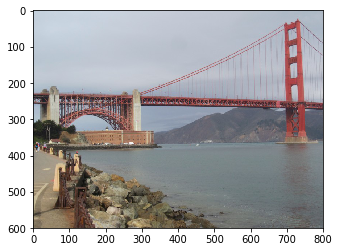

Actual Label:  Golden Gate Bridge
Predicted: Is this picture of the:  Monumento a la Revolucion ,  Dead Sea , or  Yellowstone National Park ?


In [39]:
def suggest_locations(img_path):
    # get landmark predictions
    predicted_landmarks = predict_landmarks(img_path, 3)
    
    ## TODO: display image and display landmark predictions
    image = Image.open(img_path).convert('RGB')
    plt.imshow(image)
    plt.show()
    if len(img_path.split('/')) > 2:
        actual_label = img_path.split('/')[2][3:].replace('_',' ').split('.')[0]
    else:
        actual_label = img_path.split('/')[1][3:].replace('_',' ').split('.')[0]
    print("Actual Label: ", actual_label)
    print("Predicted: Is this picture of the: ", predicted_landmarks[0], ", ", 
          predicted_landmarks[1], ", or ", predicted_landmarks[2], "?")
    
# test on a sample image
suggest_locations('images/test/09.Golden_Gate_Bridge/190f3bae17c32c37.jpg')

### (IMPLEMENTATION) Test Your Algorithm

Test your algorithm by running the `suggest_locations` function on at least four images on your computer. Feel free to use any images you like.

__Question 4:__ Is the output better than you expected :) ?  Or worse :( ?  Provide at least three possible points of improvement for your algorithm.

__Answer:__ (Three possible points for improvement)

The outputs are not accurate; the model could not identified any test images except one (Taj mahal).
However, I can do the follwoing for improvements:
1. Increase the training size by using augmentation techniques either the traditional techniques (rotation, crop, etc) or GAN-based techniques.
2. Work on tuning the model's parameters, learning rate, number of epochs, optimizer, etc.
3. Improve the model architecture and try other classifiers, such as VGG16.

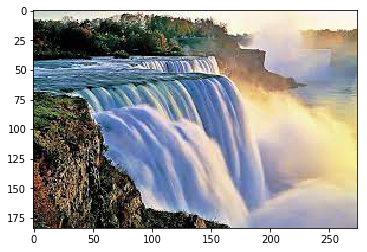

Actual Label:  niagara falls
Predicted: Is this picture of the:  Mount Rushmore National Memorial ,  Taj Mahal , or  Haleakala National Park ?


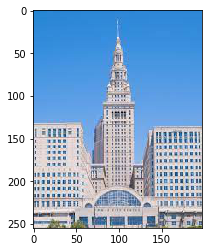

Actual Label:  terminal tower
Predicted: Is this picture of the:  Petronas Towers ,  Petronas Towers , or  Changdeokgung ?


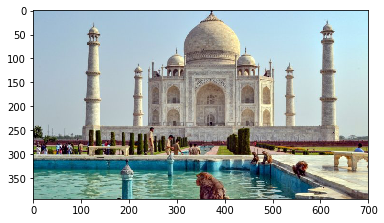

Actual Label:  taj mahal
Predicted: Is this picture of the:  Great Barrier Reef ,  Externsteine , or  Taj Mahal ?


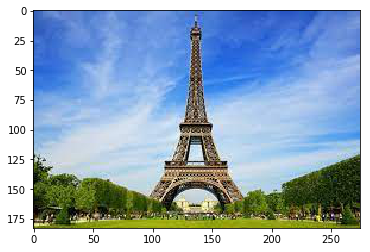

Actual Label:  effiel tower
Predicted: Is this picture of the:  Dead Sea ,  Petronas Towers , or  London Olympic Stadium ?


In [44]:
## TODO: Execute the `suggest_locations` function on
## at least 4 images on your computer.
## Feel free to use as many code cells as needed.
import os
test_images_path = 'image_from_computer/'

for img in os.listdir(test_images_path):
    img_path = os.path.join(test_images_path, img)
    if img_path.lower().endswith(('.png', '.jpg', '.jpeg')):
        suggest_locations(img_path)
